In [19]:
# Packages
import pandas as pd
import numpy as np
import geopandas as gpd
import math

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans

import statsmodels.api as sm
from scipy.spatial import distance

import matplotlib.pyplot as plt
import matplotlib as mpl

import spacv

In [2]:
# load the dataset for domestic violence prediction

df_DV = pd.read_csv("../Data/DV/DV.csv")
df_DV[["CensusBloc"]] = df_DV[["CensusBloc"]].astype(str)
y = df_DV["DV rate"]
df_DV.shape

(2146, 23)

In [3]:
# Load the CBG shapefile of Chicago

boundary = gpd.read_file("../Data/DV/chicago_cbg.shp")

In [4]:
# Create the geodataframe for the data

gdf_DV = gpd.GeoDataFrame(df_DV, geometry=gpd.points_from_xy(df_DV['Lonpro'], df_DV['Latpro']))

In [5]:
# Define the predictors

using_columns = ['population density', '% White', '% Ame Indi and AK Native', '% Asian', '% Nati Hawa and Paci Island', 
                 '% Hispanic', '% age 18-29', '% age 30-39', '% age 40-49', '% age 50-59', '% age >60', 'med income', 
                 '% unemployment', '% female hh', '% <highschool', '% security inc', '% assistant inc', '% renter hh', 
                 '% stay >=5yrs']
num_features = len(using_columns)
num_features

19

In [6]:
# Standardization function

def standarize_data(data, stats):
    return (data - stats['mean'])/stats['std']

## Random CV

In [17]:
y_predict = []
y_true = []

ten_fold = KFold(n_splits=10, shuffle=True, random_state=42)

i = 1

# Train model on folds
for train_index, test_index in ten_fold.split(df_DV):
    print("fold:", str(i))

    # Create training/test splits
    X_train_all, X_test_all = df_DV.iloc[train_index], df_DV.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train = X_train_all[using_columns]
    X_test = X_test_all[using_columns]
    
    training_stat = X_train.describe().transpose()
    X_scaled_train = standarize_data(X_train, training_stat)
    X_scaled_test = standarize_data(X_test, training_stat)
    
    # Create random forest model 
    rf = RandomForestRegressor(n_estimators=80, max_features='sqrt', random_state=42, bootstrap=False)
    rf.fit(X_scaled_train, y_train)
    
    # Generate predictions using rf model
    rf_predict = rf.predict(X_scaled_test)    
    y_predict = y_predict + list(rf_predict)
    y_true = y_true + y_test.tolist()
    
    i = i + 1

# Calculate and display RMSE and R2 scores
rmse = mean_squared_error(y_true, y_predict, squared=False)  # False means return RMSE value
r2 = r2_score(y_true, y_predict)
print("rmse: " + str(round(rmse,4)), "r2: " + str(round(r2,4)))

fold: 1
fold: 2
fold: 3
fold: 4
fold: 5
fold: 6
fold: 7
fold: 8
fold: 9
fold: 10
rmse: 8.9398 r2: 0.5952


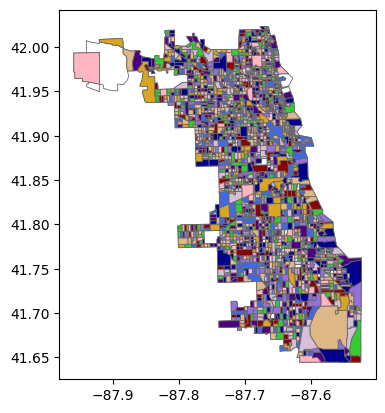

In [9]:
# Making a figure for random CV

# Create figure dimensions
fig, ax = plt.subplots(nrows=1, ncols=1)
basemap = boundary.plot(ax=ax, color='white', edgecolor='dimgrey', linewidth=0.6)
color_list = ['darkred', 'goldenrod', 'limegreen', 'burlywood', 'royalblue', 'mediumpurple', 'lightpink', 'thistle', 'indigo', 'darkblue']

# Populate figure with data
i=0
for train_index, test_index in ten_fold.split(df_DV):  
    test_index = df_DV.iloc[test_index]["CensusBloc"].astype(str).to_list()
    test_geometry = boundary.loc[boundary["CensusBloc"].isin(test_index)]
    test_geometry.plot(ax=basemap, color=color_list[i], edgecolor='dimgrey', linewidth=0.6)    
    i = i + 1

# Save figure
plt.savefig('../Data/DV/Figs/random.png', dpi=300)
plt.show()

## Clustering-based spatial CV

C:\Users\sunk\anaconda3\envs\spaCV\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


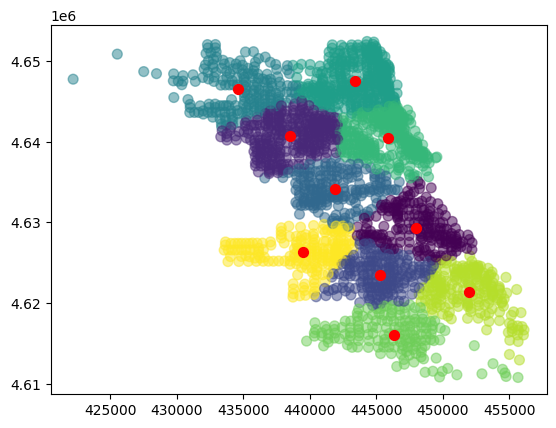

In [18]:
# Split the data based on their coordinates using k-means clustering algorithm

# Get coordinates
coordinates = df_DV[['Lonpro','Latpro']]

# Cluser data using K-means
kmeans = KMeans(n_clusters=10, random_state=42).fit(coordinates)
centroids = kmeans.cluster_centers_

# Visualize K-means clustering
plt.scatter(coordinates['Lonpro'], coordinates['Latpro'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

In [19]:
# label the cluster index for each record. 

df_DV_cluster = df_DV.copy()
df_DV_cluster["cluster"] = kmeans.labels_.tolist()
df_DV_cluster["cluster"].value_counts()

cluster
5    321
6    285
1    274
8    189
4    188
0    186
2    182
3    181
9    180
7    160
Name: count, dtype: int64

In [21]:
y_predict = []
y_true = []

group_index = df_DV_cluster['cluster'].values

group_kfold = GroupKFold(n_splits=10)

i = 1

# Train and predict on clusters
for train_index, test_index in group_kfold.split(df_DV_cluster, y, group_index):
    print("fold:", str(i))

    # Create train/test splits
    X_train_all, X_test_all = df_DV_cluster.iloc[train_index], df_DV_cluster.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train = X_train_all[using_columns]
    X_test = X_test_all[using_columns]
    
    training_stat = X_train.describe().transpose()
    X_scaled_train = standarize_data(X_train, training_stat)
    X_scaled_test = standarize_data(X_test, training_stat)
    
    # Create random forest models
    rf = RandomForestRegressor(n_estimators=80, max_features='sqrt', random_state=42, bootstrap=False)
    rf.fit(X_scaled_train, y_train)
    
    # Generate predictions using rf model
    rf_predict = rf.predict(X_scaled_test)    
    y_predict = y_predict + list(rf_predict)
    y_true = y_true + y_test.tolist()    
    
    i = i + 1

# Calculate and display RMSE & R2 
rmse = mean_squared_error(y_true, y_predict, squared=False)  # False means return RMSE value
r2 = r2_score(y_true, y_predict)
print("rmse: " + str(round(rmse,4)), "r2: " + str(round(r2,4)))

fold: 1
fold: 2
fold: 3
fold: 4
fold: 5
fold: 6
fold: 7
fold: 8
fold: 9
fold: 10
rmse: 9.4853 r2: 0.5443


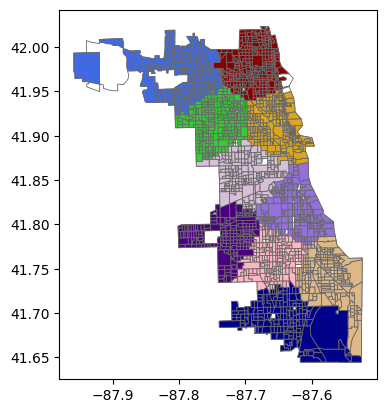

In [14]:
# Making a figure for cluster based spatial CV

# Create figure dimensions
fig, ax = plt.subplots(nrows=1, ncols=1)
basemap = boundary.plot(ax=ax, color='white', edgecolor='dimgrey', linewidth=0.6)

# Populate figure
i=0
color_list = ['darkred', 'goldenrod', 'limegreen', 'burlywood', 'royalblue', 'mediumpurple', 'lightpink', 'thistle', 'indigo', 'darkblue']
for train_index, test_index in group_kfold.split(df_DV_cluster, y, group_index):  
    test_index = df_DV_cluster.iloc[test_index]["CensusBloc"].astype(str).to_list()
    test_geometry = boundary.loc[boundary["CensusBloc"].isin(test_index)]
    test_geometry.plot(ax=basemap, color=color_list[i], edgecolor='dimgrey', linewidth=0.6)    
    i = i + 1

# Save and show figure
plt.savefig('../Data/DV/Figs/cluster.png', dpi=300)
plt.show()

## Grid-based spatial CV

In [17]:
# Split the data using grids

grid_cv = spacv.HBLOCK(3, 3, method='unique', buffer_radius=0).split(gdf_DV['geometry'])

In [18]:
y_predict = []
y_true = []

i = 1

# Train and predict on grids
for train_index, test_index in grid_cv:
    print("fold:", str(i))

    # Create train/test splits
    X_train_all, X_test_all = df_DV.iloc[train_index], df_DV.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train = X_train_all[using_columns]
    X_test = X_test_all[using_columns]
    
    training_stat = X_train.describe().transpose()
    X_scaled_train = standarize_data(X_train, training_stat)
    X_scaled_test = standarize_data(X_test, training_stat)
    
    # Create random forest model
    rf = RandomForestRegressor(n_estimators=80, max_features='sqrt', random_state=42, bootstrap=False)
    rf.fit(X_scaled_train, y_train)
    
    # Predict using rf model
    rf_predict = rf.predict(X_scaled_test)    
    y_predict = y_predict + list(rf_predict)
    y_true = y_true + y_test.tolist()
        
    i = i + 1

# Calculate and display RMSE & R2 
rmse = mean_squared_error(y_true, y_predict, squared=False)  # False means return RMSE value
r2 = r2_score(y_true, y_predict)
print("rmse: " + str(round(rmse,4)), "r2: " + str(round(r2,4)))

C:\Users\sunk\anaconda3\envs\spaCV\lib\site-packages\spacv\base_classes.py:46: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  for test_indices, train_excluded in self._iter_test_indices(XYs):


fold: 1
fold: 2
fold: 3
fold: 4
fold: 5
fold: 6
fold: 7
rmse: 9.2752 r2: 0.5643


C:\Users\sunk\anaconda3\envs\spaCV\lib\site-packages\spacv\base_classes.py:46: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  for test_indices, train_excluded in self._iter_test_indices(XYs):


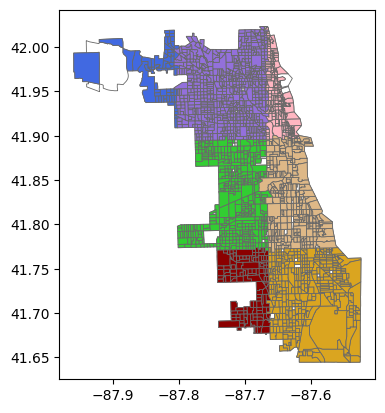

In [11]:
# Making a figure for grid based CV

# Create figure dimensions
fig, ax = plt.subplots(nrows=1, ncols=1)
basemap = boundary.plot(ax=ax, color='white', edgecolor='dimgrey', linewidth=0.6)

# Populate figure with data
i=0
color_list = ['darkred', 'goldenrod', 'limegreen', 'burlywood', 'royalblue', 'mediumpurple', 'lightpink']
for train_index, test_index in grid_cv:
    test_index = df_DV.iloc[test_index]["CensusBloc"].astype(str).to_list()
    test_geometry = boundary.loc[boundary["CensusBloc"].isin(test_index)]
    test_geometry.plot(ax=basemap, color=color_list[i], edgecolor='dimgrey', linewidth=0.6)    
    i = i + 1

# Save and display figure
plt.savefig('../Data/DV/Figs/grid.png', dpi=300)
plt.show()

## Geo-attribute-based spatial CV

In [23]:
# Load the CBG-level and neighborhoods-level data of Chicago 

gdf_cbg = gpd.read_file("../Data/DV/chicago_cbg.shp")
gdf_cbg = gdf_cbg.to_crs('epsg:26916')

gdf_neigh = gpd.read_file("../Data/DV/chicago_neighborhoods.shp")
gdf_neigh = gdf_neigh.to_crs('epsg:26916')

In [24]:
# Determine which neighborhood each CBG is located in based on the intersection area.

fid_list = []

# Search through CBGs
for index1, row1 in gdf_cbg.iterrows():
    geometry1 = row1["geometry"]
    percentage = 0
    fid = 0
    for index2, row2 in gdf_neigh.iterrows():
        geometry2 = row2["geometry"]
        fid_temp = index2
        perc_temp = (geometry1.intersection(geometry2).area/geometry1.area)*100
        if perc_temp > percentage:
            percentage = perc_temp
            fid = fid_temp
    fid_list.append(fid)

# Store unique CBGs
gdf_cbg["neigh_id"] = fid_list
gdf_cbg.neigh_id.nunique()

C:\Users\sunk\anaconda3\envs\spaCV\lib\site-packages\shapely\set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


96

In [25]:
# Label the neighborhood index of each CBG

df_DV_block = df_DV.merge(gdf_cbg[['CensusBloc','neigh_id']], how='left', left_on="CensusBloc", right_on="CensusBloc")
df_DV_block.neigh_id.nunique()

96

In [27]:
y_predict = []
y_true = []

block = df_DV_block['neigh_id'].values
group_kfold = GroupKFold(n_splits=96)

i = 1

# Train and predict on identified neighborhoods 
for train_index, test_index in group_kfold.split(df_DV_block, y, block):
    print("fold:", str(i))

    # Create train/test splits
    X_train_all, X_test_all = df_DV.iloc[train_index], df_DV.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train = X_train_all[using_columns]
    X_test = X_test_all[using_columns]
    
    training_stat = X_train.describe().transpose()
    X_scaled_train = standarize_data(X_train, training_stat)
    X_scaled_test = standarize_data(X_test, training_stat)
    
    # Create random forest model
    rf = RandomForestRegressor(n_estimators=80, max_features='sqrt', random_state=42, bootstrap=False) 
    rf.fit(X_scaled_train, y_train)
    
    # Predict using rf model
    rf_predict = rf.predict(X_scaled_test)    
    y_predict = y_predict + list(rf_predict)
    y_true = y_true + y_test.tolist()    
        
    i = i + 1

# Calculate and display RMSE & R2
rmse = mean_squared_error(y_true, y_predict, squared=False)  # False means return RMSE value
r2 = r2_score(y_true, y_predict)
print("rmse: " + str(round(rmse,4)), "r2: " + str(round(r2,4)))

fold: 1
fold: 2
fold: 3
fold: 4
fold: 5
fold: 6
fold: 7
fold: 8
fold: 9
fold: 10
fold: 11
fold: 12
fold: 13
fold: 14
fold: 15
fold: 16
fold: 17
fold: 18
fold: 19
fold: 20
fold: 21
fold: 22
fold: 23
fold: 24
fold: 25
fold: 26
fold: 27
fold: 28
fold: 29
fold: 30
fold: 31
fold: 32
fold: 33
fold: 34
fold: 35
fold: 36
fold: 37
fold: 38
fold: 39
fold: 40
fold: 41
fold: 42
fold: 43
fold: 44
fold: 45
fold: 46
fold: 47
fold: 48
fold: 49
fold: 50
fold: 51
fold: 52
fold: 53
fold: 54
fold: 55
fold: 56
fold: 57
fold: 58
fold: 59
fold: 60
fold: 61
fold: 62
fold: 63
fold: 64
fold: 65
fold: 66
fold: 67
fold: 68
fold: 69
fold: 70
fold: 71
fold: 72
fold: 73
fold: 74
fold: 75
fold: 76
fold: 77
fold: 78
fold: 79
fold: 80
fold: 81
fold: 82
fold: 83
fold: 84
fold: 85
fold: 86
fold: 87
fold: 88
fold: 89
fold: 90
fold: 91
fold: 92
fold: 93
fold: 94
fold: 95
fold: 96
rmse: 9.2501 r2: 0.5667


In [15]:
# Create a list containg a specific number of colors randomly.

import colorsys
import random
 
def get_n_hls_colors(num):
    hls_colors = []
    i = 0
    step = 360.0 / num
    while i < 360:
        h = i
        s = 90 + random.random() * 10
        l = 50 + random.random() * 10
        _hlsc = [h / 360.0, l / 100.0, s / 100.0]
        hls_colors.append(_hlsc)
        i += step
 
    return hls_colors

def ncolors(num):
    rgb_colors = []
    if num < 1:
        return rgb_colors
    hls_colors = get_n_hls_colors(num)
    for hlsc in hls_colors:
        _r, _g, _b = colorsys.hls_to_rgb(hlsc[0], hlsc[1], hlsc[2])
        r, g, b = [int(x * 255.0) for x in (_r, _g, _b)]
        rgb_colors.append([r/255, g/255, b/255])
 
    return rgb_colors

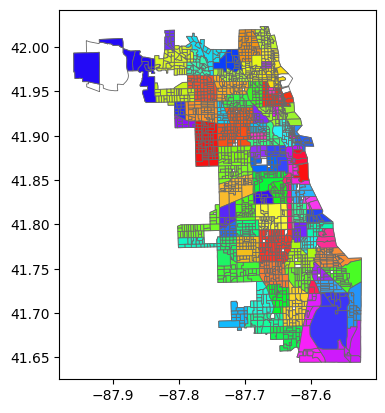

In [16]:
# Making a figure for geo-attribute based spatial CV

# Create figure dimensions
fig, ax = plt.subplots(nrows=1, ncols=1)
basemap = boundary.plot(ax=ax, color='white', edgecolor='dimgrey', linewidth=0.6)

# Populate figure with data
i = 0
color_list = ncolors(95)
for train_index, test_index in group_kfold.split(df_DV_block, y, block):  
    test_index = df_DV.iloc[test_index]["CensusBloc"].astype(str).to_list()
    test_geometry = boundary.loc[boundary["CensusBloc"].isin(test_index)]
    test_geometry.plot(ax=basemap, color=color_list[i], edgecolor='dimgrey', linewidth=0.6)    
    i = i + 1

# Save and display figure
plt.savefig('../Data/DV/Figs/geo.png', dpi=300)
plt.show()

## Spatial leave-one-out CV

In [7]:
# Compute the radius of buffer as the 0.05 quantile of distances of data

from itertools import combinations

lng_lat_coords = np.array(df_DV[['Lonpro','Latpro']])

distances = [distance.euclidean(p1, p2) for p1, p2 in combinations(lng_lat_coords, 2)]
distances_array=np.array(distances)
radius = int(np.quantile(distances_array, 0.05))

In [15]:
# Split the training and test data for each fold using the buffer_radius

skcv = spacv.SKCV(n_splits=2146, buffer_radius=radius, random_state=42).split(gdf_DV['geometry'])

In [13]:
y_predict = []
y_true = []

i = 0

for train_index, test_index in skcv:
    print("fold:", str(i))
    
    # Create train/test splits
    X_train_all, X_test_all = df_DV.iloc[train_index], df_DV.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train = X_train_all[using_columns]
    X_test = X_test_all[using_columns]
    
    training_stat = X_train.describe().transpose()
    X_scaled_train = standarize_data(X_train, training_stat)
    X_scaled_test = standarize_data(X_test, training_stat)
    
    # Create random forest model
    rf = RandomForestRegressor(n_estimators=80, max_features='sqrt', random_state=42, bootstrap=False) 
    rf.fit(X_scaled_train, y_train)
    
    # Predict using rf model
    rf_predict = rf.predict(X_scaled_test)    
    y_predict = y_predict + list(rf_predict)
    y_true = y_true + y_test.tolist()    
    
    i = i + 1

# Calculate and display RMSE & R2 
rmse = mean_squared_error(y_true, y_predict, squared=False)  # False means return RMSE value
r2 = r2_score(y_true, y_predict)
print("rmse: " + str(round(rmse,4)), "r2: " + str(round(r2,4)))

fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
fold: 5
fold: 6
fold: 7
fold: 8
fold: 9
fold: 10
fold: 11
fold: 12
fold: 13
fold: 14
fold: 15
fold: 16
fold: 17
fold: 18
fold: 19
fold: 20
fold: 21
fold: 22
fold: 23
fold: 24
fold: 25
fold: 26
fold: 27
fold: 28
fold: 29
fold: 30
fold: 31
fold: 32
fold: 33
fold: 34
fold: 35
fold: 36
fold: 37
fold: 38
fold: 39
fold: 40
fold: 41
fold: 42
fold: 43
fold: 44
fold: 45
fold: 46
fold: 47
fold: 48
fold: 49
fold: 50
fold: 51
fold: 52
fold: 53
fold: 54
fold: 55
fold: 56
fold: 57
fold: 58
fold: 59
fold: 60
fold: 61
fold: 62
fold: 63
fold: 64
fold: 65
fold: 66
fold: 67
fold: 68
fold: 69
fold: 70
fold: 71
fold: 72
fold: 73
fold: 74
fold: 75
fold: 76
fold: 77
fold: 78
fold: 79
fold: 80
fold: 81
fold: 82
fold: 83
fold: 84
fold: 85
fold: 86
fold: 87
fold: 88
fold: 89
fold: 90
fold: 91
fold: 92
fold: 93
fold: 94
fold: 95
fold: 96
fold: 97
fold: 98
fold: 99
fold: 100
fold: 101
fold: 102
fold: 103
fold: 104
fold: 105
fold: 106
fold: 107
fold: 108
fold: 109
fold: 110


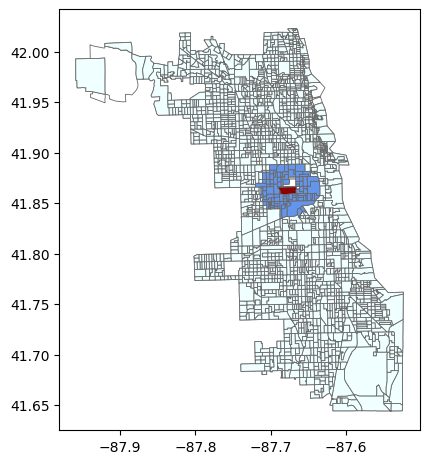

In [16]:
# Make a figure for sloo

# Create figure dimensions
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.tight_layout()
basemap = boundary.plot(ax=ax, color='white', edgecolor='dimgrey', linewidth=0.6)

# Iterate through data
for train_index, test_index in skcv:  
    test_index = df_DV.iloc[test_index]["CensusBloc"].astype(str).to_list()
    
    # Taking one census blokc of "170318429004" as the example of test sample.  
    if test_index[0] != "170318429004":
        continue
    
    # Populate map with data
    train_index = df_DV.iloc[train_index]["CensusBloc"].astype(str).to_list()
    train_exclued = list(set(df_DV['CensusBloc'].astype(str).tolist())-set(train_index)-set(test_index))
    
    test_geometry = boundary.loc[boundary["CensusBloc"].isin(test_index)]
    train_geometry = boundary.loc[boundary["CensusBloc"].isin(train_index)]
    train_exclued_geometry = boundary.loc[boundary["CensusBloc"].isin(train_exclued)]
    testmap = test_geometry.plot(ax=basemap, color='darkred', edgecolor='dimgrey', linewidth=0.6)
    trainmap = train_geometry.plot(ax=testmap, color='azure', edgecolor='dimgrey', linewidth=0.6)
    train_exclued_geometry.plot(ax=trainmap, color='cornflowerblue', edgecolor='dimgrey', linewidth=0.6)
    
    # Only show one fold of test samples, training samples, and excluded samples.
    break

# Save and display map
plt.savefig('../Data/DV/Figs/sloo.png', dpi=300)
plt.show()